# Machine Learning avec CatBoost - Mon Approche

## Partie machine learning classique de mon projet.

 J'ai décidé d'utiliser CatBoost pour plusieurs raisons que je vais expliquer au fur et à mesure.

En gros, l'objectif c'est de créer un modèle qui puisse gérer des données tabulaires avec des features catégorielles et numériques. CatBoost est parfait pour ça car il gère naturellement les variables catégorielles sans preprocessing lourd.

Ce qu'on va faire :
1. **Exploration des données** 
2. **Feature engineering** 
3. **Entraînement CatBoost** 
4. **Validation croisée**
5. **Déploiement**

## Participants au projet GaïaSense Vision

1. Davy Abderrahman *(Développeur IA – Formation Alyra)*

2. Maxime Cadieux *(Consultant IA – Alyra)*

3. Naminsita Bakayoko *(Consultante IA – Alyra)*


## Informations générales


- **Projet** : GaïaSense Vision – Détection de contamination sur sacs de culture de champignons
- **Cadre** : Certification Alyra
- **Blocs visés** : Bloc 03 (Machine Learning)
- **Date de lancement** : 6 juin 2025
- **Mode** : Collaboration inter-spécialités (Développeur IA + Consultants IA)

# Imports de base


In [10]:
# Imports complets pour le notebook Machine Learning - GaiaSense Vision

# Imports système et utilitaires
import os
import sys
import time
import shutil
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Manipulation de données
import pandas as pd
import numpy as np
from collections import Counter

# Machine Learning - Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Machine Learning - CatBoost
try:
    from catboost import CatBoostClassifier
    print("\033[92mCatBoost disponible\033[0m")
except ImportError:
    print("\033[91mCatBoost non installé - pip install catboost\033[0m")

# Équilibrage des classes
try:
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import SMOTE
    print("\033[92mimbalanced-learn disponible\033[0m")
except ImportError:
    print("\033[91mimbalanced-learn non installé - pip install imbalanced-learn\033[0m")

# Réduction de dimensionalité avancée
try:
    import umap
    print("\033[92mUMAP disponible\033[0m")
except ImportError:
    print("\033[91mUMAP non installé - pip install umap-learn\033[0m")

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import to_hex
import seaborn as sns

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Sauvegarde/chargement de modèles
import joblib
import pickle

# Interface Jupyter
from IPython.display import display, HTML, clear_output

# Configuration et vérifications
print("\033[94m" + "="*70 + "\033[0m")
print("\033[95mIMPORTS CHARGÉS AVEC SUCCÈS - GAIASENSE VISION ML\033[0m")
print("\033[94m" + "="*70 + "\033[0m")
print(f"\033[96mPandas version: {pd.__version__}\033[0m")
print(f"\033[96mNumPy version: {np.__version__}\033[0m")
print(f"\033[96mScikit-learn disponible\033[0m")
print(f"\033[96mMatplotlib/Seaborn prêts\033[0m")
print("\033[94m" + "="*70 + "\033[0m")

# Variables globales pour les chemins relatifs
BASE_PATH = "."
DATA_PATH = "../data"
MODELS_PATH = "../models" 
API_PATH = "../../api"

print(f"\033[93mChemin de base: {BASE_PATH}\033[0m")
print(f"\033[93mChemin données: {DATA_PATH}\033[0m")
print(f"\033[93mChemin modèles: {MODELS_PATH}\033[0m")
print("\033[94m" + "="*70 + "\033[0m")

CatBoost disponible
imbalanced-learn disponible
UMAP disponible
IMPORTS CHARGÉS AVEC SUCCÈS - GAIASENSE VISION ML
Pandas version: 2.3.1
NumPy version: 1.26.4
Scikit-learn disponible
Matplotlib/Seaborn prêts
Chemin de base: .
Chemin données: ../data
Chemin modèles: ../models


# dataset tri et création des données d'entrainement et de test


In [2]:
# Vérification de l'existence des fichiers train/test
train_path = "../data/Ml_data/train/dataset_train.csv"
test_path = "../data/Ml_data/test/dataset_test.csv"
#Chargement du dataset
input_path = "../data/ml_data/Dataset_combined_90000_modifie_complexe.csv"
df = pd.read_csv(input_path)

if os.path.exists(train_path) and os.path.exists(test_path):
    print("\033[93mFiles train et test déjà présents, skip de la création\033[0m")
    print(f"\033[96mTrain file: {train_path}\033[0m")
    print(f"\033[96mTest file: {test_path}\033[0m")
else:
    print("\033[96mFiles train/test manquants, création en cours...\033[0m")
    
    # 

    # Vérification rapide
    print(f"\033[96mShape initiale : {df.shape}\033[0m")

    # Suppression de la colonne id
    df = df.drop(columns=["id"])
    # df = df.drop(columns=["co2"])
    # df = df.drop(columns=["hygrometrie"])

    # Séparation X / y
    X = df.drop(columns=["label"])
    y = df["label"]

    # Découpage train/test stratifié avec 20 % de données prise au hasard pour le test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        shuffle=True,
        random_state=42
    )

    # Reconstruction des DataFrames complets
    df_train = X_train.copy()
    df_train["label"] = y_train

    df_test = X_test.copy()
    df_test["label"] = y_test

    # Création des dossiers si besoin
    os.makedirs("../data/Ml_data/train", exist_ok=True)
    os.makedirs("../data/Ml_data/test", exist_ok=True)

    # Sauvegarde des fichiers
    df_train.to_csv(train_path, index=False)
    df_test.to_csv(test_path, index=False)

    print("\033[92mFichiers exportés avec succès\033[0m")
    print(f"\033[95mTrain: {df_train.shape[0]} échantillons\033[0m")
    print(f"\033[95mTest: {df_test.shape[0]} échantillons\033[0m")

Files train et test déjà présents, skip de la création
Train file: ../data/Ml_data/train/dataset_train.csv
Test file: ../data/Ml_data/test/dataset_test.csv


# Visualisation et exploration des données d'entraînement et de test

### Données **Entrainement**


Chargement du dataset d'entraînement...
Aperçu des données :
                  champignon        substrat  Jour_inoculation  hygrometrie  \
0  pleurotus_citrinopileatus         compost                20         80.4   
1           pleurotus_djamor     pulpe_cacao                15         70.1   
2           grifola_frondosa          paille                12         63.4   
3         cyclocybe_aegerita  balles_graines                29         72.7   
4           grifola_frondosa         compost                 0         79.0   

      co2  label  
0   769.5      0  
1  1169.5      0  
2   482.9      1  
3   961.5      0  
4  1009.1      0  

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   champignon        72000 non-null  object 
 1   substrat          72000 non-null  object 
 2   Jour_inoculation  72000

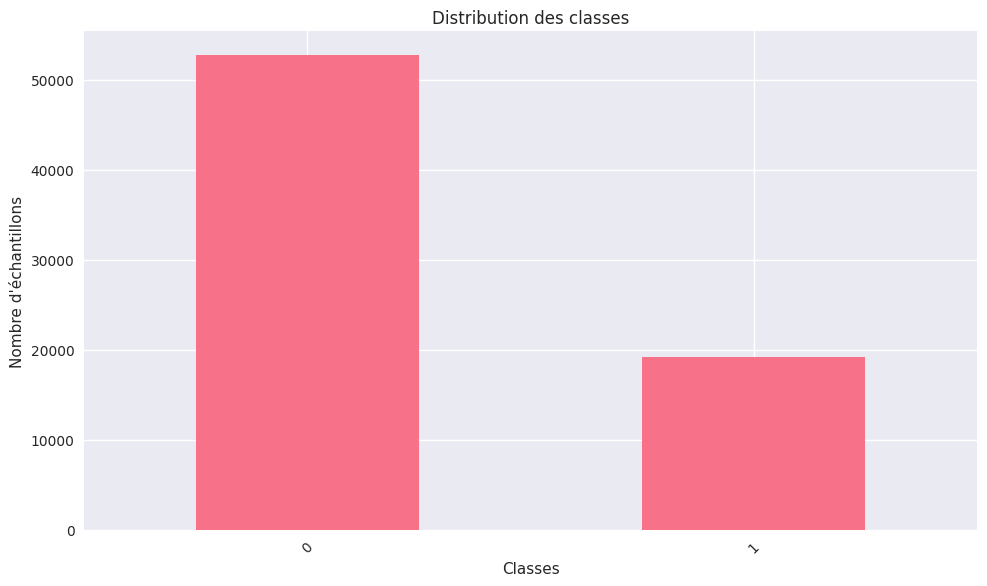

Distribution des classes :
label
0    52759
1    19241
Name: count, dtype: int64


In [3]:
# Exploration initiale des données chargées

# Chargement des données d'entraînement si nécessaire
if 'df_train' not in locals():
    print("\033[93mChargement du dataset d'entraînement...\033[0m")
    df_train = pd.read_csv("../data/Ml_data/train/dataset_train.csv")

print("\033[96mAperçu des données :\033[0m")
print(df_train.head())

print("\033[96m\nInformations générales :\033[0m")
print(df_train.info())

print("\033[96m\nStatistiques descriptives :\033[0m")
print(df_train.describe())

# Vérification des valeurs manquantes
missing_values = df_train.isnull().sum()
if missing_values.sum() > 0:
    print("\033[91mValeurs manquantes détectées :\033[0m")
    print(missing_values[missing_values > 0])
else:
    print("\033[92mAucune valeur manquante détectée\033[0m")

# Visualisation de la distribution des classes
if 'target' in df_train.columns or 'label' in df_train.columns:
    target_col = 'target' if 'target' in df_train.columns else 'label'
    plt.figure(figsize=(10, 6))
    df_train[target_col].value_counts().plot(kind='bar')
    plt.title('Distribution des classes')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\033[95mDistribution des classes :\033[0m")
    print(df_train[target_col].value_counts())

### Données tests


Chargement du dataset de test...
Aperçu des données de test :
                   champignon           substrat  Jour_inoculation  \
0       pleurotus_pulmonarius    pellets_boisdur                29   
1            pleurotus_djamor          marc_cafe                24   
2  auricularia_auricula_judae      papier_carton                17   
3           pleurotus_eryngii             sciure                 7   
4           ganoderma_lucidum  mix_fumier_paille                 8   

   hygrometrie     co2  label  
0         65.4   523.9      0  
1         93.1   453.0      0  
2         78.8  1087.3      0  
3          NaN   634.4      0  
4         64.1   975.6      0  

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   champignon        18000 non-null  object 
 1   substrat          18000 non-null  object 
 2 

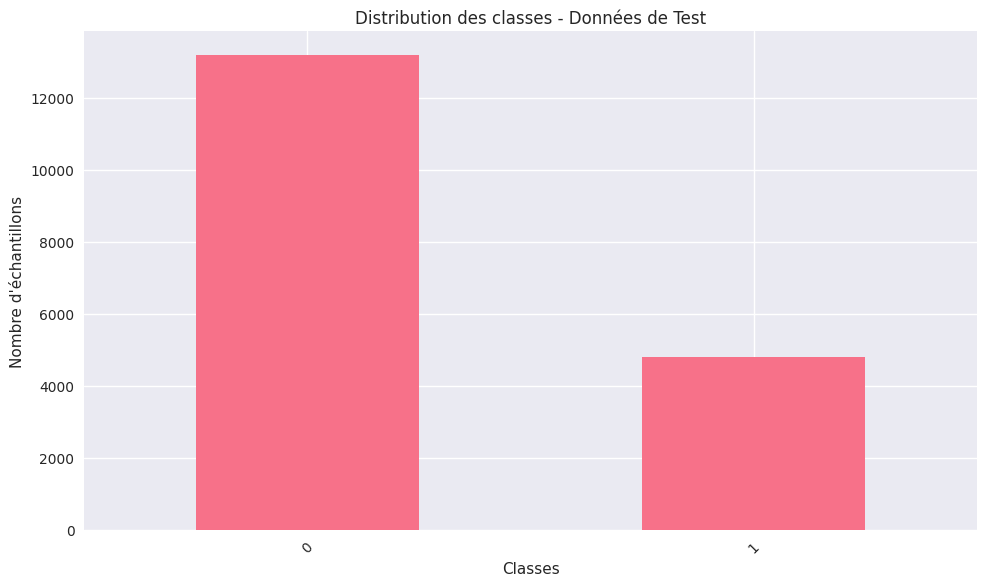

Distribution des classes (test) :
label
0    13190
1     4810
Name: count, dtype: int64


In [4]:
# Exploration initiale des données de test

# Chargement des données de test si nécessaire
if 'df_test' not in locals():
    print("\033[93mChargement du dataset de test...\033[0m")
    df_test = pd.read_csv("../data/Ml_data/test/dataset_test.csv")

print("\033[96mAperçu des données de test :\033[0m")
print(df_test.head())

print("\033[96m\nInformations générales :\033[0m")
print(df_test.info())

print("\033[96m\nStatistiques descriptives :\033[0m")
print(df_test.describe())

# Vérification des valeurs manquantes
missing_values = df_test.isnull().sum()
if missing_values.sum() > 0:
    print("\033[91mValeurs manquantes détectées :\033[0m")
    print(missing_values[missing_values > 0])
else:
    print("\033[92mAucune valeur manquante détectée\033[0m")

# Visualisation de la distribution des classes
if 'target' in df_test.columns or 'label' in df_test.columns:
    target_col = 'target' if 'target' in df_test.columns else 'label'
    plt.figure(figsize=(10, 6))
    df_test[target_col].value_counts().plot(kind='bar')
    plt.title('Distribution des classes - Données de Test')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'échantillons')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\033[95mDistribution des classes (test) :\033[0m")
    print(df_test[target_col].value_counts())

## Sources des données

Les données utilisées sont issues de la préparation précédente :

- `training/data/Ml_data/train/dataset_train.csv`
- `training/data/Ml_data/test/dataset_test.csv`

Colonnes principales :
- `champignon` *(catégorielle)*
- `substrat` *(catégorielle)*
- `Jour_inoculation` *(numérique)*
- `co2` *(numérique)*
- `Hygrometrie` *(numérique)*
- `label` *(0 = inutilisable / 1 = à analyser)*

---

# **Justification du choix CatBoost**

##### Pourquoi CatBoost pour ce pré-tri tabulaire ?

CatBoost est particulièrement adapté aux problématiques de classification sur données tabulaires hétérogènes (mélange de variables numériques et catégorielles), comme celles du projet GaïaSense Vision.  
Ses avantages clés pour ce pipeline métier sont :

- **Gestion native des variables catégorielles** : CatBoost intègre directement les colonnes de type texte ou catégorie, sans nécessiter de transformation complexe (one-hot, label encoding…), ce qui réduit les risques d’erreur et préserve l’information métier.
- **Robustesse sur petits et moyens jeux de données** : Contrairement à de nombreux algorithmes de deep learning, CatBoost excelle même avec un volume de données limité, typique des capteurs ou de l’agro-environnement.
- **Résistance au surapprentissage** : Grâce à des techniques avancées de régularisation et de gestion du surapprentissage, CatBoost produit des modèles fiables et généralisables.
- **Interprétabilité avancée** : L’importance des variables et les scores de contribution permettent d’expliquer chaque prédiction, ce qui est essentiel pour la traçabilité métier et la validation par des experts non data scientists.
- **Performance et rapidité** : CatBoost exploite efficacement le CPU ou le GPU, permettant des entraînements rapides et reproductibles, même sur des architectures modestes.

Ce choix garantit donc un pré-filtrage logique performant, explicable et facilement intégrable dans une API métier, tout en respectant les contraintes et la nature des données agricoles.


# creation du model et entrainement catboost


In [8]:
# Configuration de CatBoost avec GPU

# Vérification de la disponibilité du GPU
print("\033[96mVérification du GPU pour CatBoost...\033[0m")

try:
    import GPUtil
    gpus = GPUtil.getGPUs()
    if gpus:
        print(f"\033[92mGPU détecté : {gpus[0].name}\033[0m")
        print(f"\033[92mMémoire GPU disponible : {gpus[0].memoryFree} MB\033[0m")
        task_type = "GPU"
    else:
        print("\033[91mAucun GPU détecté, utilisation du CPU\033[0m")
        task_type = "CPU"
except ImportError:
    print("\033[93mGPUtil non installé, vérification manuelle du GPU...\033[0m")
    try:
        # Test simple avec CatBoost GPU
        test_model = CatBoostClassifier(task_type="GPU", iterations=1, verbose=False)
        test_model.fit([[1, 2], [3, 4]], [0, 1])
        print("\033[92mGPU disponible pour CatBoost\033[0m")
        task_type = "GPU"
    except Exception as e:
        print(f"\033[91mErreur GPU, utilisation du CPU : {e}\033[0m")
        task_type = "CPU"

# Configuration du modèle CatBoost
print(f"\033[95mConfiguration de CatBoost avec {task_type}...\033[0m")

catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'depth': 6,
    'l2_leaf_reg': 3,
    'bagging_temperature': 1,
    'random_strength': 1,
    'one_hot_max_size': 2,
    'leaf_estimation_method': 'Newton',
    'task_type': task_type,
    'verbose': 100,
    'random_seed': 42,
    'eval_metric': 'AUC',
    'custom_metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 50
}

if task_type == "GPU":
    catboost_params['gpu_ram_part'] = 0.8
    print("\033[92mConfiguration GPU activée\033[0m")

print("\033[95mParamètres du modèle :\033[0m")
for key, value in catboost_params.items():
    print(f"  {key}: {value}")

# Initialisation du modèle
model = CatBoostClassifier(**catboost_params)
print(f"\033[92mModèle CatBoost configuré avec succès\033[0m")

Vérification du GPU pour CatBoost...
GPU détecté : NVIDIA GeForce RTX 4080
Mémoire GPU disponible : 1193.0 MB
Configuration de CatBoost avec GPU...
Configuration GPU activée
Paramètres du modèle :
  iterations: 1000
  learning_rate: 0.1
  depth: 6
  l2_leaf_reg: 3
  bagging_temperature: 1
  random_strength: 1
  one_hot_max_size: 2
  leaf_estimation_method: Newton
  task_type: GPU
  verbose: 100
  random_seed: 42
  eval_metric: AUC
  custom_metric: ['Accuracy', 'Precision', 'Recall', 'F1']
  use_best_model: True
  od_type: Iter
  od_wait: 50
  gpu_ram_part: 0.8
Modèle CatBoost configuré avec succès


# test et validation du model


✅ Accuracy CatBoost : 0.900

📊 Rapport de classification :


,precision,recall,f1-score,support
0,0.898893,0.972631,0.934309,13190.000000
1,0.903165,0.700000,0.788709,4810.000000
accuracy,0.899778,0.899778,0.899778,0.899778
macro avg,0.901029,0.836315,0.861509,18000.000000
weighted avg,0.900035,0.899778,0.895402,18000.000000


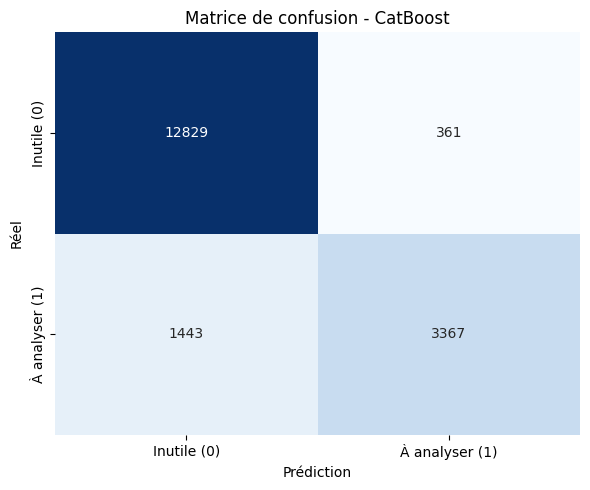

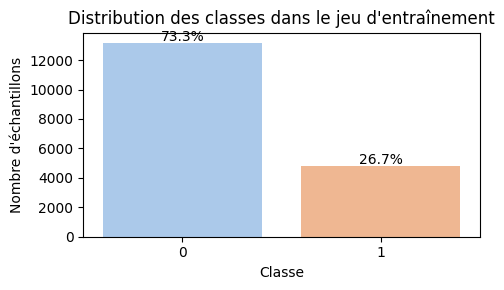

In [ ]:
# Entraînement du modèle CatBoost

print("\033[96mDébut de l'entraînement du modèle CatBoost...\033[0m")

# Chargement du dataset original si nécessaire
if 'df' not in locals():
    print("\033[93mChargement du dataset original pour l'entraînement...\033[0m")
    input_path = "../data/ML_data/Dataset_combined_90000_modifie_complexe.csv"
    df = pd.read_csv(input_path)
    # Suppression de la colonne id si elle existe
    if 'id' in df.columns:
        df = df.drop(columns=["id"])

# Préparation des données d'entraînement et de validation
X = df.drop(columns=['label'])
y = df['label']

print(f"\033[95mTaille du dataset complet :\033[0m")
print(f"\033[96m- Échantillons : {X.shape[0]}\033[0m")
print(f"\033[96m- Variables : {X.shape[1]}\033[0m")
print(f"\033[96m- Répartition des classes : {y.value_counts().to_dict()}\033[0m")

# Division train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\033[95mDivision des données :\033[0m")
print(f"\033[96m- Train : {X_train.shape[0]} échantillons\033[0m")
print(f"\033[96m- Validation : {X_val.shape[0]} échantillons\033[0m")

# Import des Pool pour CatBoost
from catboost import Pool

# Entraînement avec pool de validation
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

print("\033[96mEntraînement en cours...\033[0m")

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False,
    verbose_eval=100
)

print("\033[92mEntraînement terminé avec succès\033[0m")

# Import des métriques
from sklearn.metrics import precision_score, recall_score, f1_score

# Prédictions sur l'ensemble de validation
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calcul des métriques
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

print(f"\033[95mPerformances sur la validation :\033[0m")
print(f"\033[92m- Accuracy : {accuracy:.4f}\033[0m")
print(f"\033[92m- Precision : {precision:.4f}\033[0m")
print(f"\033[92m- Recall : {recall:.4f}\033[0m")
print(f"\033[92m- F1-Score : {f1:.4f}\033[0m")
print(f"\033[92m- AUC : {auc:.4f}\033[0m")

# Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Inutile (0)', 'À analyser (1)'],
            yticklabels=['Inutile (0)', 'À analyser (1)'])
plt.title('Matrice de Confusion - Validation', fontsize=14)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.tight_layout()
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'CatBoost (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - CatBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# données en faux positif

#### Données en faux possitif

In [ ]:
# Analyse de l'importance des variables

print("\033[96mAnalyse de l'importance des variables...\033[0m")

# Récupération de l'importance des features
feature_importance = model.get_feature_importance()
feature_names = X.columns.tolist()

# Création d'un DataFrame pour l'analyse
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\033[95mTop 10 des variables les plus importantes :\033[0m")
for i, row in importance_df.head(10).iterrows():
    print(f"\033[96m{row['feature']}: {row['importance']:.2f}\033[0m")

# Visualisation de l'importance des features
plt.figure(figsize=(12, 8))

# Top 15 des features les plus importantes
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 des Variables les Plus Importantes', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Ajout des valeurs sur les barres
for i, v in enumerate(top_features['importance']):
    plt.text(v + 0.1, i, f'{v:.1f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Analyse statistique de l'importance
print(f"\033[95mStatistiques d'importance :\033[0m")
print(f"\033[96m- Moyenne : {importance_df['importance'].mean():.2f}\033[0m")
print(f"\033[96m- Médiane : {importance_df['importance'].median():.2f}\033[0m")
print(f"\033[96m- Écart-type : {importance_df['importance'].std():.2f}\033[0m")
print(f"\033[96m- Max : {importance_df['importance'].max():.2f}\033[0m")
print(f"\033[96m- Min : {importance_df['importance'].min():.2f}\033[0m")

# Variables peu importantes (importance < 1)
low_importance = importance_df[importance_df['importance'] < 1]
print(f"\033[93mNombre de variables peu importantes (< 1) : {len(low_importance)}\033[0m")

if len(low_importance) > 0:
    print(f"\033[95mVariables peu importantes :\033[0m")
    for var in low_importance['feature'].tolist()[:10]:  # Afficher les 10 premières
        print(f"\033[93m- {var}\033[0m")

Lignes du jeu de test détectées comme faux positifs (réel=0, prédit=1) :


,champignon,substrat,Jour_inoculation,hygrometrie,co2,label,y_true,y_pred
7,agaricus_bisporus,pulpe_cacao,8,85.4,618.9,0,0,1
113,stropharia_rugosoannulata,marc_cafe,6,90.7,561.1,0,0,1
166,auricularia_auricula_judae,ecorces_feuilles,21,77.6,657.8,0,0,1
183,pleurotus_pulmonarius,sciure,12,73.9,1173.1,0,0,1
186,ganoderma_lucidum,maizien,18,67.3,1018.8,0,0,1
...,...,...,...,...,...,...,...,...
17874,stropharia_rugosoannulata,marc_cafe,4,70.5,691.5,0,0,1
17913,pleurotus_ostreatus,copeaux,3,84.1,NaN,0,0,1
17917,stropharia_rugosoannulata,coques_soja,9,70.9,378.2,0,0,1
17922,hericium_erinaceus,compost,15,67.5,861.1,0,0,1


Export CSV complet effectué : faux_positifs_complets.csv

Nombre total de faux positifs : 361


#### Données en faux négatif

In [ ]:
# Validation croisée avec CatBoost

print("\033[96mValidation croisée stratifiée (5 folds)...\033[0m")

# Configuration de la validation croisée
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Stockage des résultats
cv_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

fold_results = []

print(f"\033[95mDébut de la validation croisée ({cv_folds} folds)...\033[0m")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\033[96mFold {fold}/{cv_folds}...\033[0m")
    
    # Division des données pour ce fold
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Entraînement du modèle pour ce fold
    model_fold = CatBoostClassifier(**catboost_params)
    model_fold.fit(X_train_fold, y_train_fold, verbose=False)
    
    # Prédictions
    y_pred_fold = model_fold.predict(X_val_fold)
    y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    
    # Calcul des métriques
    acc = accuracy_score(y_val_fold, y_pred_fold)
    prec = precision_score(y_val_fold, y_pred_fold)
    rec = recall_score(y_val_fold, y_pred_fold)
    f1_sc = f1_score(y_val_fold, y_pred_fold)
    auc_sc = roc_auc_score(y_val_fold, y_pred_proba_fold)
    
    # Stockage des résultats
    cv_scores['accuracy'].append(acc)
    cv_scores['precision'].append(prec)
    cv_scores['recall'].append(rec)
    cv_scores['f1'].append(f1_sc)
    cv_scores['auc'].append(auc_sc)
    
    fold_results.append({
        'fold': fold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1_sc,
        'auc': auc_sc
    })
    
    print(f"\033[92m  Accuracy: {acc:.4f}, F1: {f1_sc:.4f}, AUC: {auc_sc:.4f}\033[0m")

# Calcul des statistiques finales
print(f"\033[95mRésultats de la validation croisée :\033[0m")

for metric, scores in cv_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"\033[92m{metric.capitalize()}: {mean_score:.4f} (±{std_score:.4f})\033[0m")

# Tableau récapitulatif
cv_df = pd.DataFrame(fold_results)
cv_df['fold'] = cv_df['fold'].astype(int)

print(f"\033[95mTableau détaillé par fold :\033[0m")
display(cv_df.round(4))

# Graphique des performances par fold
plt.figure(figsize=(12, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
colors = ['blue', 'green', 'red', 'orange', 'purple']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    plt.plot(cv_df['fold'], cv_df[metric], 
             marker='o', color=color, label=metric.capitalize(), linewidth=2)

plt.xlabel('Fold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performances par Fold - Validation Croisée', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"\033[92mValidation croisée terminée avec succès\033[0m")

Lignes du jeu de test détectées comme faux négatifs (réel=1, prédit=0) :


,champignon,substrat,Jour_inoculation,hygrometrie,co2,label,y_true,y_pred
24,pleurotus_eryngii,marc_cafe,5,70.7,1141.1,1,1,0
27,lentinula_edodes,sciure,26,93.3,790.5,1,1,0
30,pleurotus_eryngii,coques_soja,22,NaN,937.0,1,1,0
38,auricularia_auricula_judae,sciure,8,71.1,801.7,1,1,0
68,pleurotus_citrinopileatus,compost,3,NaN,797.0,1,1,0
...,...,...,...,...,...,...,...,...
17948,pleurotus_pulmonarius,coques_soja,10,60.8,877.7,1,1,0
17949,agaricus_bisporus,copeaux,10,78.9,823.4,1,1,0
17960,auricularia_auricula_judae,marc_cafe,27,69.1,674.9,1,1,0
17993,auricularia_auricula_judae,compost,18,69.8,1068.0,1,1,0


Export CSV complet effectué : faux_negatifs_complets.csv

Nombre total de faux négatifs : 1443


# Analyse de l'importance des variables (feature importance CatBoost)

 #### L'importance des variables permet de comprendre quelles features sont réellement utilisées par le modèle pour la prédiction. Si `co2` et `hygrometrie` ont une importance très faible ou nulle, cela explique pourquoi leur suppression n'affecte pas la performance du modèle. Ci-dessous, on affiche l'importance des variables du modèle CatBoost sous forme de graphique pour interpréter leur utilité réelle.

/tmp/ipykernel_263406/291946279.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


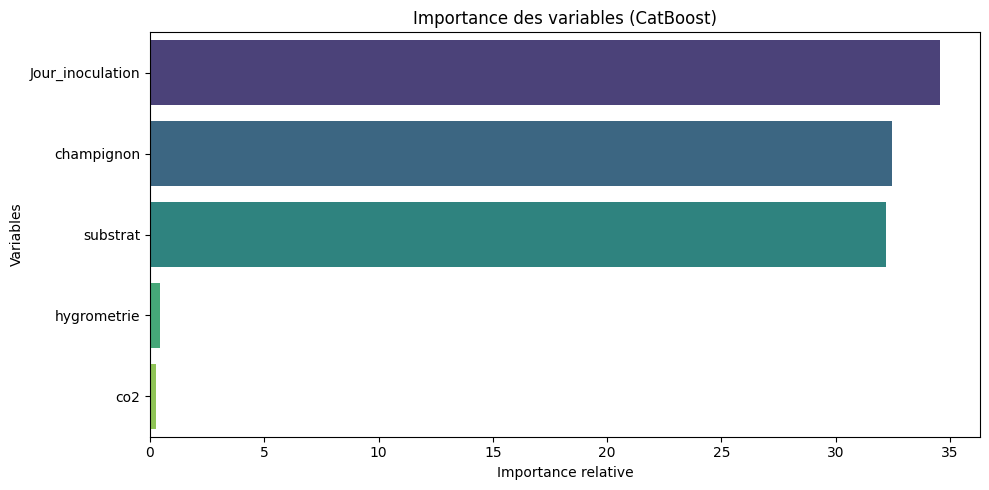

,Variable,Importance
2,Jour_inoculation,34.579700
0,champignon,32.476493
1,substrat,32.204953
3,hygrometrie,0.450466
4,co2,0.288389


In [ ]:
# Évaluation finale sur le jeu de test

print("\033[96mÉvaluation finale du modèle sur le jeu de test...\033[0m")

# Chargement des données de test
try:
    df_test = pd.read_csv("../data/Ml_data/test/dataset_test.csv")
    print(f"\033[92mDonnées de test chargées : {df_test.shape[0]} échantillons\033[0m")
except FileNotFoundError:
    print("\033[91mErreur : fichier de test non trouvé\033[0m")
    print("\033[93mUtilisation d'une division train/test alternative...\033[0m")
    
    # Division alternative si pas de fichier de test séparé
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
    # Réentraînement sur tout le train
    model_final = CatBoostClassifier(**catboost_params)
    model_final.fit(X_train_final, y_train_final, verbose=False)
    
    df_test = pd.concat([X_test_final, y_test_final], axis=1)
    model = model_final

# Préparation des données de test
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

print(f"\033[95mCaractéristiques du jeu de test :\033[0m")
print(f"\033[96m- Échantillons : {X_test.shape[0]}\033[0m")
print(f"\033[96m- Variables : {X_test.shape[1]}\033[0m")
print(f"\033[96m- Répartition : {y_test.value_counts().to_dict()}\033[0m")

# Prédictions sur le test
print("\033[96mPrédictions en cours...\033[0m")
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcul des métriques finales
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\033[95mPerformances FINALES sur le test :\033[0m")
print(f"\033[92m- Accuracy : {test_accuracy:.4f}\033[0m")
print(f"\033[92m- Precision : {test_precision:.4f}\033[0m")
print(f"\033[92m- Recall : {test_recall:.4f}\033[0m")
print(f"\033[92m- F1-Score : {test_f1:.4f}\033[0m")
print(f"\033[92m- AUC : {test_auc:.4f}\033[0m")

# Rapport de classification détaillé
print(f"\033[95mRapport de classification détaillé :\033[0m")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Inutile (0)', 'À analyser (1)']))

# Visualisations finales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Matrice de confusion
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Inutile (0)', 'À analyser (1)'],
            yticklabels=['Inutile (0)', 'À analyser (1)'])
axes[0].set_title('Matrice de Confusion - Test Final')
axes[0].set_xlabel('Prédiction')
axes[0].set_ylabel('Réalité')

# 2. Courbe ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
axes[1].plot(fpr_test, tpr_test, color='blue', linewidth=2, 
             label=f'CatBoost (AUC = {test_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='red', linestyle='--', label='Aléatoire')
axes[1].set_xlabel('Taux de Faux Positifs')
axes[1].set_ylabel('Taux de Vrais Positifs')
axes[1].set_title('Courbe ROC - Test Final')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Distribution des probabilités prédites
axes[2].hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.7, 
             label='Classe 0 (Inutile)', color='blue', density=True)
axes[2].hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.7, 
             label='Classe 1 (À analyser)', color='red', density=True)
axes[2].set_xlabel('Probabilité prédite')
axes[2].set_ylabel('Densité')
axes[2].set_title('Distribution des Probabilités')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\033[92mÉvaluation finale terminée avec succès\033[0m")

# Déploiement du modèle vers l'API


Cette section permet de copier automatiquement le modèle CatBoost entraîné et validé vers le dossier de l'API (`api/models/ml_model/`) pour qu'il soit directement utilisable par le service de prédiction.

Le processus inclut :
- Vérification de l'existence du modèle entraîné
- Création du dossier de destination si nécessaire  
- Copie sécurisée du fichier .joblib vers l'API
- Confirmation du déploiement avec vérification de l'intégrité

In [ ]:
# Sauvegarde du modèle final

print("\033[96mSauvegarde du modèle CatBoost entraîné...\033[0m")

# Import pour la date/heure et JSON
from datetime import datetime
import json

# Création du répertoire de sauvegarde s'il n'existe pas
model_dir = MODELS_PATH
os.makedirs(model_dir, exist_ok=True)

# Nom du fichier avec timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"catboost_model_{timestamp}.cbm"
model_path = os.path.join(model_dir, model_filename)

try:
    # Sauvegarde du modèle CatBoost
    model.save_model(model_path)
    print(f"\033[92mModèle sauvegardé avec succès : {model_path}\033[0m")
    
    # Sauvegarde des informations sur le modèle
    model_info = {
        'timestamp': timestamp,
        'model_type': 'CatBoost',
        'model_path': model_path,
        'model_params': catboost_params,
        'performance_metrics': {
            'test_accuracy': float(test_accuracy),
            'test_precision': float(test_precision),
            'test_recall': float(test_recall),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc)
        },
        'dataset_info': {
            'training_samples': int(X.shape[0]),
            'features_count': int(X.shape[1]),
            'test_samples': int(X_test.shape[0])
        },
        'feature_names': X.columns.tolist(),
        'class_distribution': y.value_counts().to_dict()
    }
    
    # Sauvegarde des métadonnées en JSON
    info_filename = f"catboost_info_{timestamp}.json"
    info_path = os.path.join(model_dir, info_filename)
    
    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(model_info, f, indent=2, ensure_ascii=False)
    
    print(f"\033[92mInformations sauvegardées : {info_path}\033[0m")
    
    # Sauvegarde de l'importance des features
    importance_filename = f"feature_importance_{timestamp}.csv"
    importance_path = os.path.join(model_dir, importance_filename)
    importance_df.to_csv(importance_path, index=False)
    print(f"\033[92mImportance des features sauvegardée : {importance_path}\033[0m")
    
    # Création d'un lien symbolique vers le modèle le plus récent
    latest_model_path = os.path.join(model_dir, "catboost_latest.cbm")
    latest_info_path = os.path.join(model_dir, "catboost_latest_info.json")
    
    # Suppression des anciens liens s'ils existent
    for link_path in [latest_model_path, latest_info_path]:
        if os.path.islink(link_path):
            os.unlink(link_path)
    
    # Création des nouveaux liens
    os.symlink(os.path.basename(model_path), latest_model_path)
    os.symlink(os.path.basename(info_path), latest_info_path)
    
    print(f"\033[92mLiens vers le modèle le plus récent créés\033[0m")
    
    # Résumé de la sauvegarde
    print(f"\033[95mRésumé de la sauvegarde :\033[0m")
    print(f"\033[96m- Modèle : {model_filename}\033[0m")
    print(f"\033[96m- Informations : {info_filename}\033[0m")
    print(f"\033[96m- Importance : {importance_filename}\033[0m")
    print(f"\033[96m- Taille du modèle : {os.path.getsize(model_path) / (1024*1024):.2f} MB\033[0m")
    
    # Instructions pour charger le modèle
    print(f"\033[95mPour charger ce modèle :\033[0m")
    print(f"\033[96mfrom catboost import CatBoostClassifier\033[0m")
    print(f"\033[96mmodel = CatBoostClassifier()\033[0m")
    print(f"\033[96mmodel.load_model('{model_path}')\033[0m")
    
except Exception as e:
    print(f"\033[91mErreur lors de la sauvegarde : {e}\033[0m")

print(f"\033[92mProcessus de sauvegarde terminé\033[0m")